In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import time
import sklearn
import warnings
import pickle

warnings.filterwarnings(action='ignore', category=FutureWarning)

pd.__version__, sklearn.__version__

('2.1.1', '1.2.1')

In [2]:
SCRATCH_DIR = "/scratch/siads696f23_class_root/siads696f23_class/psollars"

In [3]:
start_time = time.time()
all_features_2019 = pd.read_parquet(f"{SCRATCH_DIR}/all_features_2019.parquet")
end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 12.0166 seconds


In [4]:
# Feature selection from "feature_selection_2019_UA-for-real.ipynb"

num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "FlightDate",
    "Tail_Number",
    "Origin",
    "DestCityMarketID",
    "Dest",
    "N-NUMBER",
    "MFR MDL CODE",
    "ENG MFR MDL",
    "TYPE REGISTRANT",
    "NAME",
    "CERTIFICATION",
    "TYPE ENGINE",
    "STATUS CODE",
    "MODE S CODE",
    "MODE S CODE HEX",
    "CODE",
    "MFR",
    "MODEL",
    "TYPE",
    "CODE_aircraft",
    "MFR_aircraft",
    "MODEL_aircraft",
    "TYPE-ENG",
    "BUILD-CERT-IND",
    "faa_registration_origin",
    "Origin_DISPLAY_AIRPORT_NAME",
    "Origin_DISPLAY_AIRPORT_CITY_NAME_FULL",
    "Dest_DISPLAY_AIRPORT_NAME",
    "Dest_DISPLAY_AIRPORT_CITY_NAME_FULL",
]

In [5]:
start_time = time.time()

united_df = all_features_2019[all_features_2019["Reporting_Airline"].eq("UA")].drop("Reporting_Airline", axis=1)

df = united_df[united_df["Cancelled"].eq(0) & united_df["Diverted"].eq(0)].copy()

df = df[df["Origin"].eq("ORD") | df["Dest"].eq("ORD")]

df["delayed"] = (df["DepDel15"].eq(1)) | (df["ArrDel15"].eq(1))

# Column YEAR MFR contains non-convertible values.
df["YEAR MFR"] = df["YEAR MFR"].replace(r'^\s*$', np.nan, regex=True)

df_features = df[num_cols + cat_cols + ["delayed"]]

df_features = df_features.dropna(axis="index", how=("any"))

end_time = time.time()

print(f"Removed {len(united_df) - len(df)}  rows")

print(f"Removed {len(df) - len(df_features)} NaN rows")

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

df_features

Removed 484833  rows
Removed 858 NaN rows
Elapsed time: 3.4020 seconds


,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,MFR_aircraft,MODEL_aircraft,TYPE-ENG,BUILD-CERT-IND,faa_registration_origin,Origin_DISPLAY_AIRPORT_NAME,Origin_DISPLAY_AIRPORT_CITY_NAME_FULL,Dest_DISPLAY_AIRPORT_NAME,Dest_DISPLAY_AIRPORT_CITY_NAME_FULL,delayed
25272188,1,1,22,2,1315,1932,257,1846,8,2001,...,BOEING,757-33N,5.0,0.0,2023.0,San Francisco International,"San Francisco, CA",Chicago O'Hare International,"Chicago, IL",True
25272196,1,1,22,2,1000,1144,164,733,3,2002,...,BOEING,737-700,5.0,0.0,2023.0,LaGuardia,"New York, NY",Chicago O'Hare International,"Chicago, IL",False
25272197,1,1,22,2,1430,1650,80,296,2,2015,...,BOEING,737-924ER,5.0,0.0,2023.0,Chicago O'Hare International,"Chicago, IL",John Glenn Columbus International,"Columbus, OH",True
25272202,1,1,22,2,1011,1200,169,888,4,2004,...,BOEING,757-324,5.0,0.0,2023.0,Chicago O'Hare International,"Chicago, IL",Denver International,"Denver, CO",True
25272222,1,1,22,2,1423,2024,241,1723,7,2004,...,BOEING,737-824,5.0,0.0,2023.0,San Diego International,"San Diego, CA",Chicago O'Hare International,"Chicago, IL",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32219984,4,12,28,6,1747,2014,207,1197,5,1994,...,AIRBUS INDUSTRIE,A320-232,5.0,0.0,2023.0,Miami International,"Miami, FL",Chicago O'Hare International,"Chicago, IL",True
32219989,4,12,28,6,0755,1049,174,925,4,2014,...,BOEING,737-924ER,5.0,0.0,2023.0,Chicago O'Hare International,"Chicago, IL",George Bush Intercontinental/Houston,"Houston, TX",False
32219991,4,12,28,6,2324,0510,226,1739,7,1999,...,BOEING,737-824,5.0,0.0,2023.0,Portland International,"Portland, OR",Chicago O'Hare International,"Chicago, IL",False
32219994,4,12,28,6,0745,1145,180,1120,5,2008,...,BOEING,737-924ER,5.0,0.0,2023.0,Chicago O'Hare International,"Chicago, IL",Southwest Florida International,"Fort Myers, FL",False


In [6]:
df_features.value_counts("delayed")

delayed
False    114714
True      39646
Name: count, dtype: int64

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


def preprocess_data(preprocess_df):
    start_time = time.time()

    X = preprocess_df.drop("delayed", axis=1)
    y = preprocess_df["delayed"]

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(), cat_cols),
        ]
    )

    X_transformed = preprocessor.fit_transform(X)

    end_time = time.time()

    print(f"Finished Preprocessing: {(end_time - start_time):.4f} seconds")

    return X_transformed, y

In [9]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 7.2 MB/s eta 0:00:0000:0100:01


In [11]:
import xgboost as xgb

xgb.__version__

'2.0.0'

In [14]:
import xgboost as xgb


def fit_xg_boost(fit_X_train, fit_y_train):
    start_time = time.time()
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'scale_pos_weight': sum(y_train == 0) / sum(y_train == 1),  # Handle imbalance
    }


    bst = xgb.train(params, dtrain)
    
    end_time = time.time()
    
    print(f"Finished Fitting Model: {(end_time - start_time):.4f} seconds")
    
    return bst

In [34]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


def fit_grid_search_xg_boost(fit_X_train, fit_y_train):
    start_time = time.time()
    
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'n_estimators': [50, 100, 150],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'scale_pos_weight': [sum(y_train == 0) / sum(y_train == 1)]  # Handle imbalance
    }

    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    
    grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,
                           scoring='average_precision',  # AUC-PR
                           cv=5, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    
    print(f"Finished Fitting Model: {(end_time - start_time):.4f} seconds")
    
    return grid_search

In [38]:
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 5,
 'n_estimators': 150,
 'scale_pos_weight': 2.8772959904549595,
 'subsample': 0.8}

In [35]:
from sklearn.model_selection import train_test_split

start_time = time.time()

X, y = preprocess_data(df_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

model = fit_grid_search_xg_boost(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Finished Preprocessing: 1.6302 seconds


/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/psollars/.local/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is 

Finished Fitting Model: 163.0485 seconds
Elapsed time: 164.7717 seconds


In [36]:
with open(f"{SCRATCH_DIR}/11_grid_search_xg_boost_2019_ORD_UA.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
# with open(f"{SCRATCH_DIR}/08_GridSearchCV_2019_ORD_UA.pkl", "wb") as f:
#     pickle.dump(model, f)

# Model Evaluation

In [ ]:
# with open(f"{SCRATCH_DIR}/11_grid_search_xg_boost_2019_ORD_UA.pkl", "rb") as f:
#     model = pickle.load(f)

In [42]:
best_estimator = model.best_estimator_

In [47]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve,
)

# y_pred_raw = model.predict(dtest)

# # Make the predictions binary
# y_pred = [1 if y > 0.5 else 0 for y in y_pred]

y_pred = best_estimator.predict(X_test)

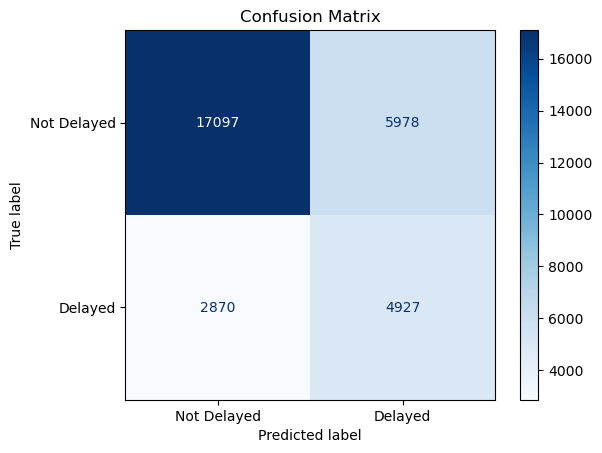

In [48]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Delayed", "Delayed"]
).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [49]:
cm

array([[17097,  5978],
       [ 2870,  4927]])

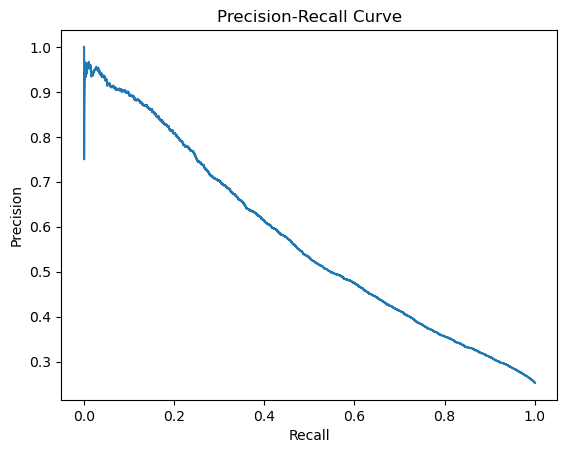

In [50]:
y_scores = model.best_estimator_.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.step(recall, precision, where="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [55]:
from sklearn.metrics import roc_auc_score


y_pred_proba = model.best_estimator_.predict_proba(X_test)

ra_score = roc_auc_score(y_test, y_pred, average="macro", multi_class="ovr")

ra_score

0.6864207265872045

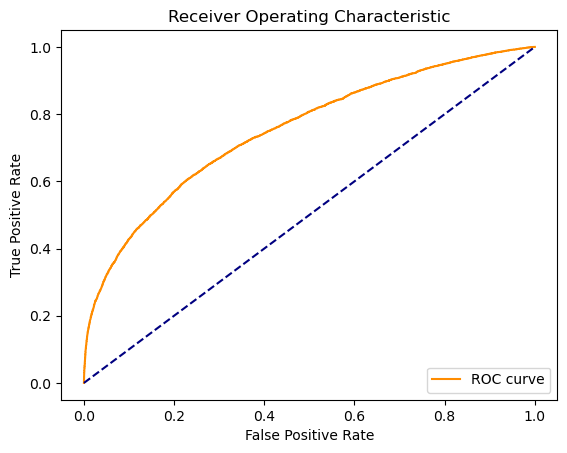

In [56]:
fpr, tpr, _ = roc_curve(y_test, model.best_estimator_.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [54]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics_scores = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
}
df_metrics = pd.DataFrame(list(metrics_scores.items()), columns=["Metric", "Score"])

fig = px.bar(
    df_metrics,
    x="Score",
    y="Metric",
    orientation="h",
    color="Metric",
    text="Score",
    title="Evaluation Metrics",
)

fig.update_layout(showlegend=False)

fig.show()